In [120]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import json
import random
random.seed(1024)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [96]:
class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score

    def sentiment(self):
        if self.score <= 2:
            return "NEGATIVE"
        if self.score == 3:
            return "NEUTRAL"
        else:
            return "POSITIVE"
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews

    def get_text(self):
        return [_.text for _ in self.reviews]
    
    def get_sentiment(self):
        return [_.sentiment() for _ in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda _: _.sentiment() == "NEGATIVE", self.reviews))
        positive = list(filter(lambda _: _.sentiment() == "POSITIVE", self.reviews))
        random.shuffle(positive)
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)


In [97]:
fn = './data/Books_small_10000.json'
reviews = []
with open(fn, 'r') as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))

reviews[0].text

"I bought both boxed sets, books 1-5.  Really a great series!  Start book 1 three weeks ago and just finished book 5.  Sloane Monroe is a great character and being able to follow her through both private life and her PI life gets a reader very involved!  Although clues may be right in front of the reader, there are twists and turns that keep one guessing until the last page!  These are books you won't be disappointed with."

### Prep Data

In [98]:
train, test = train_test_split(reviews, test_size=0.33, random_state=42)
train_cont = ReviewContainer(train)
test_cont = ReviewContainer(test)

In [99]:
train_cont.evenly_distribute()
train_x = train_cont.get_text()
train_y = train_cont.get_sentiment()

test_cont.evenly_distribute()
test_x = test_cont.get_text()
test_y = test_cont.get_sentiment()

print(train_y.count('POSITIVE'))
print(train_y.count('NEGATIVE'))

436
436


### Bag of words vectorization

In [100]:
vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)
train_x_vectors.toarray()

test_x_vectors = vectorizer.transform(test_x)
test_x_vectors.toarray()
# vectorizer.get_stop_words()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Classification

In [101]:
print(test_x[0])

Where to start... the men's conversations were women's, I know a few men and they just don't talk like that.  There was a lot of repetition, to the point of boring. Both women were old enough to act more maturely.  Character development was nonexistant for all four of the main characters.  And there was no murderer mystery development.  There were murders and then they caught the guy but it wasn't him then they caught the real guy.  Ho hum.  Clues?  None.  Motive?  He was crazy.  Ho hum.


#### Linear SVM

In [102]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(train_x_vectors, train_y)
clf_svm.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

#### Decision Tree

In [103]:
from sklearn.tree import DecisionTreeClassifier
clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)
clf_dec.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

#### Naive Bayes

In [104]:
from sklearn.naive_bayes import GaussianNB
clf_gnf = GaussianNB()
clf_gnf.fit(train_x_vectors.toarray(), train_y)
clf_gnf.predict(test_x_vectors.toarray()[0].reshape(1, -1))

array(['POSITIVE'], dtype='<U8')

#### Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()
clf_log.fit(train_x_vectors, train_y)
clf_log.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

### Evaluation

#### Mean Accuracy

In [106]:
clf_svm.score(test_x_vectors, test_y)

0.8173076923076923

In [107]:
clf_dec.score(test_x_vectors, test_y)

0.6298076923076923

In [108]:
clf_gnf.score(test_x_vectors.toarray(), test_y)

0.5504807692307693

In [109]:
clf_log.score(test_x_vectors, test_y)

0.8293269230769231

#### F1 score

each class has a f1 score

In [110]:
from sklearn.metrics import f1_score
f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([0.81904762, 0.        , 0.81553398])

### Tuning our models (with Grid Search)

In [116]:
from sklearn.model_selection import GridSearchCV

params = {'kernel': ('linear', 'rbf'), 'C': (0.5,1,4)}
svc = svm.SVC()
clf = GridSearchCV(svc, params, cv=5)
clf.fit(train_x_vectors, train_y)
clf.best_params_

{'C': 4, 'kernel': 'rbf'}

In [115]:
clf.score(test_x_vectors, test_y)

0.8293269230769231

### Saving Model

#### save

In [117]:
import pickle

with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

#### load

In [118]:
with open('./models/sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [119]:
loaded_clf.predict(test_x_vectors[0])

array(['NEGATIVE'], dtype='<U8')

### Confusion Matrix

<Axes: >

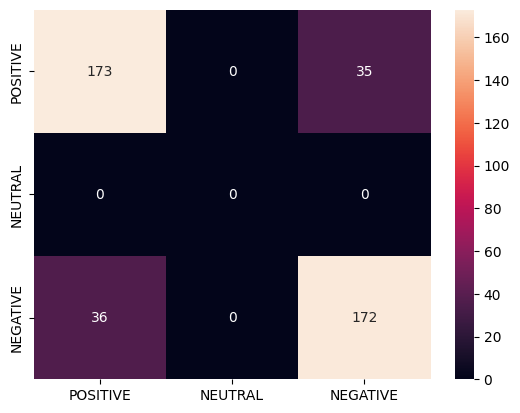

In [124]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(test_x_vectors)
labels = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')